In [1]:
from netCDF4 import *
import matplotlib.pyplot as plt
import matplotlib.colors as co
from path import Path
import xarray as xr
import numpy as np
import math
import scipy.interpolate as interp
import scipy.stats as stats
import tkinter as tk
import cv2
import matplotlib
import pandas as pd

from matplotlib import rc

font = {"family": "serif", "weight": "normal", "size": 13}
rc("font", **font)
rc("text", usetex=True)

### Import data

In [2]:
path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\data\\GLORYS\\GPGP_flow_2022_06;09_processed.nc")
dsr = xr.open_dataset(path, engine="netcdf4")
path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Work\data\\GLORYS\\GPGP_flow_2022_06;09.nc")
dsrf = xr.open_dataset(path, engine="netcdf4")

owp = dsr["owp_th"]
vorticity = dsr["vorticity"]
speed = dsr["speed"]
long = -142.5
lat = 24.5
DL = 5
trange = [0,40,80,120]

export_boundaries = [long-DL/2,long+DL/2,lat-DL/2,lat+DL/2]#left, right, bottom, top
xbound = [export_boundaries[0],export_boundaries[1],export_boundaries[1],export_boundaries[0],export_boundaries[0]]
ybound = [export_boundaries[3],export_boundaries[3],export_boundaries[2],export_boundaries[2],export_boundaries[3]]

## Local minimum detection + speed threshold filtering

In [3]:
# OWP Thresholding without CV2
# 
#  pos_min = []

# for t,time in enumerate(trange):
#     pos_min.append([])
#     print("Time : "+str(time))
#     for i in range(dsr["latitude"].shape[0]):
#         for j in range(dsr["longitude"].shape[0]):
#             if owp[time,i,j] < owp[time,i,j-1] and owp[time,i,j] < owp[time,i,j+1] and owp[time,i,j] < owp[time,i-1,j] and owp[time,i,j] < owp[time,i+1,j] :
#                 if np.abs(speed[time,i,j]) < 0.10 : 
#                     pos_min[t].append([dsr["latitude"][i],dsr["longitude"][j],owp[time,i,j]])
# print("Num points : "+ str(len(pos_min[t])))
   

In [4]:
#OWP Thresholding with CV2

pos_min = []

for t,time in enumerate(trange) :
    pos_min.append([])
    print("Time : "+str(time))
    min = np.min(owp)
    max = np.max(owp)
    owp_fit_gray = np.array((owp[t,:,:]+min)*255/(max-min), dtype=np.uint8)
    owp_rgb = cv2.cvtColor(owp_fit_gray, cv2.COLOR_GRAY2RGB)

    _,owp_tresh = cv2.threshold(owp_fit_gray, 62, 255, cv2.THRESH_BINARY)


    contours,_ = cv2.findContours(owp_tresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_filtered = []
    height = dsr["latitude"].shape[0]
    width = dsr["longitude"].shape[0]

    #contour filtering
    for c,cnt in enumerate(contours) :
        rect = cv2.boundingRect(cnt)
        print(float(dsr["longitude"][rect[0]]),float(dsr["longitude"][rect[1]]))
        if dsr["longitude"][rect[0]] > export_boundaries[0] and dsr["longitude"][rect[0]] < export_boundaries[1] and dsr["latitude"][rect[1]] > export_boundaries[2] and dsr["latitude"][rect[1]] < export_boundaries[3] :
            # if float(rect[2]/width) > 0.005 and float(rect[3]/height) > 0.005 and float(rect[2]/width) < 0.8 and float(rect[3]/height) < 0.8 :
            contours_filtered.append(cnt)
            pos_min[t].append([dsr["latitude"][int(rect[1]+rect[3]/2)],dsr["longitude"][int(rect[0]+rect[2]/2)],owp[t,int(rect[1]+rect[3]/2),int(rect[0]+rect[2]/2)]])

    img = cv2.drawContours(owp_rgb, contours_filtered,-1,(0,255,20), 2)
    cv2.imshow('owp', img)
cv2.waitKey(0)

# closing all open windows
cv2.destroyAllWindows()

Time : 0
-137.0833282470703 -130.25
-149.3333282470703 -130.25
-135.1666717529297 -130.5
-136.4166717529297 -130.5
-135.6666717529297 -130.66665649414062
-139.0833282470703 -130.66665649414062
-153.0 -130.66665649414062
-154.5833282470703 -130.8333282470703
-134.16665649414062 -130.91665649414062
-132.8333282470703 -131.0833282470703
-134.66665649414062 -131.0833282470703
-153.5 -131.0833282470703
-133.3333282470703 -131.25
-152.75 -131.25
-136.4166717529297 -131.3333282470703
-153.25 -131.3333282470703
-132.91665649414062 -131.5
-140.6666717529297 -131.91665649414062
-130.91665649414062 -132.0
-140.5 -132.0833282470703
-154.0 -132.0833282470703
-137.5 -132.16665649414062
-135.0833282470703 -132.25
-145.4166717529297 -132.3333282470703
-140.5 -132.41665649414062
-142.0833282470703 -132.5
-147.3333282470703 -132.5
-135.0 -132.66665649414062
-138.1666717529297 -132.8333282470703
-150.6666717529297 -132.91665649414062
-132.75 -133.0
-153.75 -133.0
-152.0 -133.16665649414062
-131.083328247

c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


Time : 40
-137.0 -130.25
-135.0833282470703 -130.5
-136.4166717529297 -130.5
-135.6666717529297 -130.66665649414062
-154.5833282470703 -130.75
-134.16665649414062 -130.91665649414062
-134.66665649414062 -131.0833282470703
-153.5 -131.0833282470703
-136.5833282470703 -131.25
-152.75 -131.25
-133.3333282470703 -131.3333282470703
-153.25 -131.3333282470703
-136.4166717529297 -131.41665649414062
-150.5833282470703 -131.41665649414062
-132.8333282470703 -131.5
-139.6666717529297 -131.91665649414062
-140.6666717529297 -131.91665649414062
-130.91665649414062 -132.0833282470703
-132.3333282470703 -132.0833282470703
-154.0 -132.0833282470703
-137.5 -132.16665649414062
-135.0833282470703 -132.25
-145.4166717529297 -132.3333282470703
-140.5 -132.41665649414062
-142.0833282470703 -132.41665649414062
-142.75 -132.41665649414062
-131.25 -132.5
-147.3333282470703 -132.5
-135.0833282470703 -132.66665649414062
-138.1666717529297 -132.91665649414062
-153.75 -132.91665649414062
-132.5833282470703 -133.0


c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


Time : 80
-137.0 -130.3333282470703
-135.0833282470703 -130.5
-135.6666717529297 -130.66665649414062
-139.0 -130.66665649414062
-154.5833282470703 -130.75
-134.0833282470703 -130.91665649414062
-134.66665649414062 -131.0833282470703
-153.5 -131.0833282470703
-136.1666717529297 -131.25
-153.25 -131.25
-133.3333282470703 -131.3333282470703
-152.75 -131.3333282470703
-150.75 -131.41665649414062
-132.75 -131.5
-133.0833282470703 -131.5
-151.3333282470703 -131.8333282470703
-139.6666717529297 -131.91665649414062
-140.6666717529297 -131.91665649414062
-130.91665649414062 -132.0
-154.0 -132.0
-137.4166717529297 -132.16665649414062
-135.0833282470703 -132.25
-145.4166717529297 -132.3333282470703
-140.4166717529297 -132.41665649414062
-142.0 -132.41665649414062
-131.3333282470703 -132.5
-135.1666717529297 -132.66665649414062
-138.0833282470703 -132.8333282470703
-150.6666717529297 -132.91665649414062
-153.8333282470703 -132.91665649414062
-132.41665649414062 -133.0
-151.9166717529297 -133.16665

c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)
c:\Users\albou\AppData\Local\Programs\Python\Python310\lib\site-packages\xarray\core\common.py:181: RuntimeWarning: invalid value encountered in cast
  return np.array(self.values, dtype=dtype, copy=copy)


-141.5833282470703 -150.1666717529297
-149.8333282470703 -150.1666717529297
-138.5 -150.25
-140.5833282470703 -150.4166717529297
-143.0 -150.5833282470703
-144.1666717529297 -150.6666717529297
-145.25 -150.75
-139.5 -150.8333282470703
-154.0 -150.8333282470703
-135.25 -151.0
-152.5833282470703 -151.0
-134.16665649414062 -151.1666717529297
-141.4166717529297 -151.4166717529297
-145.9166717529297 -151.4166717529297
-143.3333282470703 -151.5833282470703
-144.9166717529297 -151.5833282470703
-136.9166717529297 -151.6666717529297
-146.1666717529297 -151.6666717529297
-145.4166717529297 -151.75
-142.5 -151.9166717529297
-135.0 -152.0
-140.5833282470703 -152.0
-138.6666717529297 -152.0833282470703
-149.0 -152.0833282470703
-136.8333282470703 -152.1666717529297
-144.0 -152.25
-132.3333282470703 -152.4166717529297
-142.0833282470703 -152.4166717529297
-139.0 -152.5
-143.9166717529297 -152.5
-133.5 -152.5833282470703
-138.5 -152.6666717529297
-148.5 -152.6666717529297
-143.8333282470703 -152.75


In [5]:
# pos_min = []


# for t,time in enumerate(trange):
#     img = np.array(owp[t,:,:])

#     pos_min.append([])
#     print("Time : "+str(time))
#     for i in range(dsr["latitude"].shape[0]):
#         for j in range(dsr["longitude"].shape[0]):
#             if owp[time,i,j] < owp[time,i,j-1] and owp[time,i,j] < owp[time,i,j+1] and owp[time,i,j] < owp[time,i-1,j] and owp[time,i,j] < owp[time,i+1,j] :
#                 if np.abs(speed[time,i,j]) < 0.10 : 
#                     pos_min[t].append([dsr["latitude"][i],dsr["longitude"][j],owp[time,i,j]])
# print("Num points : "+ str(len(pos_min[t])))
   

## Show detection points on vorticity and owp map

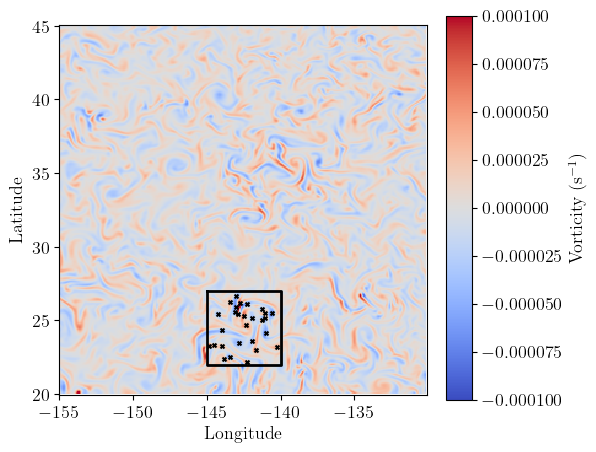

In [6]:
fig, ax = plt.subplots()
# plt.quiver(dsrf["uo"], dsrf["vo"])

value = 0.00010
im = ax.pcolormesh(dsr["longitude"], dsr["latitude"], vorticity[0], cmap="coolwarm", vmax =value, vmin = -value)
coco = ['red','purple','blue','green','orange']
for t in [0]:
    for i in range(len(pos_min[t])):
        ax.scatter(pos_min[t][i][1], pos_min[t][i][0],s=8, color= "black", marker = 'x')
        # ax.text(pos_min[t][i][1], pos_min[t][i][0],str(t), fontsize=10)
ax.plot(xbound, ybound, color='black', linewidth=2)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar_ax = fig.add_axes([0.83, 0.10, 0.04, 0.8])
fig.colorbar(im,cax = cbar_ax,label = "Vorticity (s$^{-1}$)")
#fig.savefig("owp_vortex_detection.pdf")


## Function definition

In [7]:
def circulation(ds,N,W,radius,time):
    #compute the circulation around a circle of given radius (in km) centered on (N,W) at given time index

    if W > 0 :
        W -= 360
    R = 6.371e6 #radius of the Earth
    pR = 2*np.pi*R

    u = np.array(ds["uo"])
    v = np.array(ds["vo"])
        
    pts = 40

    xcircle = np.cos(np.linspace(0,6.28,pts))*(radius*1000) 
    ycircle = np.sin(np.linspace(0,6.28,pts))*(radius*1000)

    # Alternative square path
    # xcircle = np.concatenate([np.linspace(-1,1,int(pts/4)),np.linspace(1,1,int(pts/4)),np.linspace(1,-1,int(pts/4)),np.linspace(-1,-1,int(pts/4))])*radius*1000
    # ycircle = np.concatenate([np.linspace(-1,-1,int(pts/4)),np.linspace(-1,1,int(pts/4)),np.linspace(1,1,int(pts/4)),np.linspace(1,-1,int(pts/4))])*radius*1000

    ycircle /= pR/360
    ycircle += np.array(N)
    xcircle /= pR*np.cos(np.deg2rad(ycircle))/360
    xcircle += np.array(W) 

    circulation = 0

    # Xc,Yc = np.meshgrid(np.linspace(np.min(ds["longitude"]),np.max(ds["longitude"]),u.shape[2]),np.linspace(np.min(ds["latitude"]),np.max(ds["latitude"]),u.shape[3]), indexing='ij')
    Xc = np.linspace(np.min(ds["longitude"]),np.max(ds["longitude"]),u.shape[3])
    Yc = np.linspace(np.min(ds["latitude"]),np.max(ds["latitude"]),u.shape[2])


    ui = u[time,0,:,:].astype("float64")
    vi = v[time,0,:,:].astype("float64")

    fu = interp.RegularGridInterpolator((Xc,Yc), ui.T)
    fv = interp.RegularGridInterpolator((Xc,Yc), vi.T)

    for i in range(1,len(xcircle)) :
        
        if xcircle[i] < np.min(Xc) or xcircle[i] > np.max(Xc) or ycircle[i] < np.min(Yc) or ycircle[i] > np.max(Yc):
            return 0,0

        dlx = (xcircle[i] - xcircle[i-1])*pR*np.cos(np.deg2rad(ycircle[i]))/360
        dly = (ycircle[i] - ycircle[i-1])*pR/360

        ul = fu((xcircle[i],ycircle[i]))
        vl = fv((xcircle[i],ycircle[i]))


        circulation += ul*dlx + vl*dly

        tg_spd = circulation/(2*3.1415*radius*1000)
    
    return circulation,tg_spd



In [8]:
def lamb_oseen_fit(spd_profile,circ_profile):
    #fit a lamb-oseen profile to the given speed and circulation profiles (1D arrays)
    spd_argmax = np.argmax(np.abs(spd_profile))
    rmax = 1+spd_argmax*2
    circ = circ_profile[spd_argmax]/0.71
    return rmax,circ

In [9]:
def flat(array) :
    array_ret = []
    for i in range(len(array)):
        array_ret.extend(array[i])
    return array_ret

## Lamb oseen approximation computation with time series

In [10]:
#velocity profile
spd_profile = []
#circulation profile
circulation_profile = []    
coords = []
rmax = []   
circ = []
ids = []

for t,time in enumerate(trange) :
    print("Time : "+str(t))
    rmax.append([])
    circ.append([])
    coords.append([])
    ids.append([])
    for i in range(len(pos_min[t])):
        for j in range(1,100,2) :
            result = circulation(dsrf,pos_min[t][i][0],pos_min[t][i][1],radius=j,time=t)
            if np.isnan(result[0])  or (len(spd_profile) > 0 and np.abs(spd_profile[-1]) >np.abs(result[1])) :
                #extraction of the parameters
                rmaxi,circi = lamb_oseen_fit(spd_profile,circulation_profile)
                rmax[-1].append(rmaxi)
                circ[-1].append(circi)
                coords[-1].append([pos_min[t][i][0],pos_min[t][i][1],j])
                
                if t ==0:
                    ids[-1].append(i)
                else:
                    for k in range(len(ids[-2])):
                        dist = np.power(coords[-2][k][0]-coords[-1][-1][0],2)+ np.power(coords[-2][k][1]-coords[-1][-1][1],2)
                        if dist < 1 :
                            ids[-1].append(ids[-2][k])
                            break
                spd_profile = []
                circulation_profile = []
                break
            spd_profile.append(result[1])
            circulation_profile.append(result[0])

Time : 0
Time : 1
Time : 2
Time : 3


In [11]:
with open("LO_list", "a") as f:
  for i in range(len(rmax[0])):
    if coords[0][i][0] > export_boundaries[2] and coords[0][i][0] < export_boundaries[3] and coords[0][i][1] > export_boundaries[0] and coords[0][i][1] < export_boundaries[1] :
      coordsx = int((float(coords[0][i][1]) - long)*110000)
      coordsy = int((float(coords[0][i][0]) - lat)*110000)
      f.write(str(coordsx)+" "+str(coordsy)+" "+str(round(rmax[0][i]*1000/math.sqrt(1.25643),0))+" "+str(round(circ[0][i],0))+"\n")

In [12]:
dsr.close()
dsrf.close()